# Comparison to CCL

This notebook compares the implementation from jax_cosmo to CCL

In [1]:

import numpy as np

import os
os.environ['JAX_ENABLE_X64']='True'
#os.chdir("/pbs/home/c/campagne/my_sps/jax-cosmo-forked-tmp/jax_cosmo/")
#os.getcwd()

In [2]:
import pyccl as ccl
import jax
import jax_cosmo
from jax_cosmo import Cosmology, background

2022-08-22 17:22:49.037506: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2022-08-22 17:22:49.097189: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2022-08-22 17:22:49.102601: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [4]:
class MathTextSciFormatter(mticker.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            s =  r'%s%s' % (significand, exponent)
        return "${}$".format(s)

In [5]:

jax_cosmo.__version__

'0.1rc9'

In [6]:
ccl.__version__

'2.5.1'

In [7]:
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 16

In [8]:
# We first define equivalent CCL and jax_cosmo cosmologies

ccl.spline_params.A_SPLINE_NLOG=5*1024
ccl.physical_constants['T_CMB'] = 2.726  # as jax-cosmo

cosmo_ccl= ccl.Cosmology(
    Omega_c=0.3, Omega_b=0.05, h=0.7, sigma8 = 0.8, n_s=0.96, 
    Neff=0,Omega_g=0,
    transfer_function='eisenstein_hu', matter_power_spectrum='halofit')

cosmo_jax = Cosmology(Omega_c=0.3, Omega_b=0.05, h=0.7, sigma8 = 0.8, n_s=0.96,
                      Omega_k=0., w0=-1., wa=0.)

## Comparing background cosmology

In [9]:
# Test array of scale factors
a_min = 0.01
z_max = 1./(1.+a_min)
a = np.linspace(a_min, 1.,100)

2022-08-22 17:22:52.352444: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2022-08-22 17:22:52.352509: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


Text(0.5, 0, 'a')

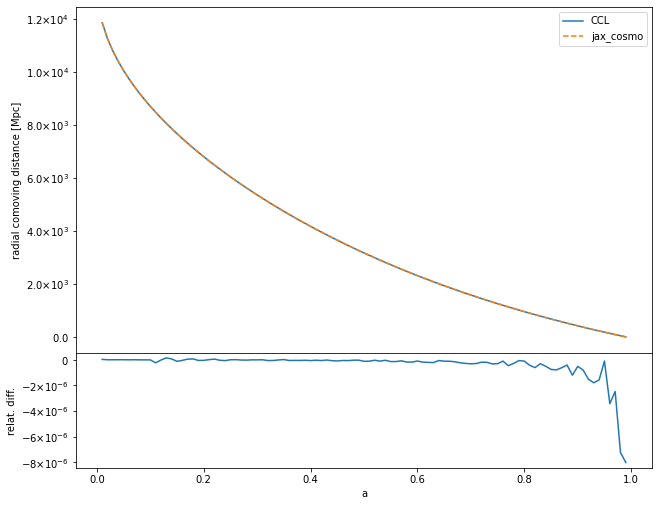

In [10]:
# Testing the radial comoving distance
fig1 = plt.figure(1, figsize=(10,8))
frame1=fig1.add_axes((.1,.3,.8,.6))

chi_ccl = ccl.comoving_radial_distance(cosmo_ccl, a)
cosmo_jax._workspace = {}
chi_jax = background.radial_comoving_distance(cosmo_jax, a, log10_amin=np.log10(a_min),steps=5*1024)/cosmo_jax.h

plt.plot(a, chi_ccl, label='CCL')
plt.plot(a, chi_jax, '--', label='jax_cosmo')
plt.legend()
plt.ylabel('radial comoving distance [Mpc]')
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.1e"))
frame1.set_xticklabels([])

#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))
difference=(chi_ccl-chi_jax)/chi_ccl
plt.plot(a,difference)

plt.ylabel(r"relat. diff.");
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.e"))

plt.xlabel('a')

Text(0.5, 0, 'a')

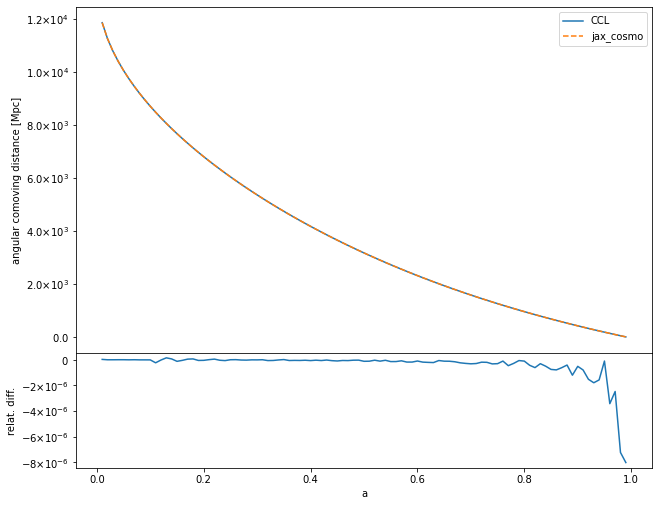

In [11]:
# Testing the angular comoving distance
fig1 = plt.figure(1, figsize=(10,8))
frame1=fig1.add_axes((.1,.3,.8,.6))
chi_ccl = ccl.comoving_angular_distance(cosmo_ccl, a)
chi_jax = background.transverse_comoving_distance(cosmo_jax, a)/cosmo_jax.h

plt.plot(a, chi_ccl, label='CCL')
plt.plot(a, chi_jax, '--', label='jax_cosmo')
plt.legend()
plt.ylabel('angular comoving distance [Mpc]')
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.1e"))

#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))
difference=(chi_ccl-chi_jax)/chi_ccl
plt.plot(a,difference)
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

plt.ylabel(r"relat. diff.");
plt.xlabel('a')

Text(0.5, 0, 'a')

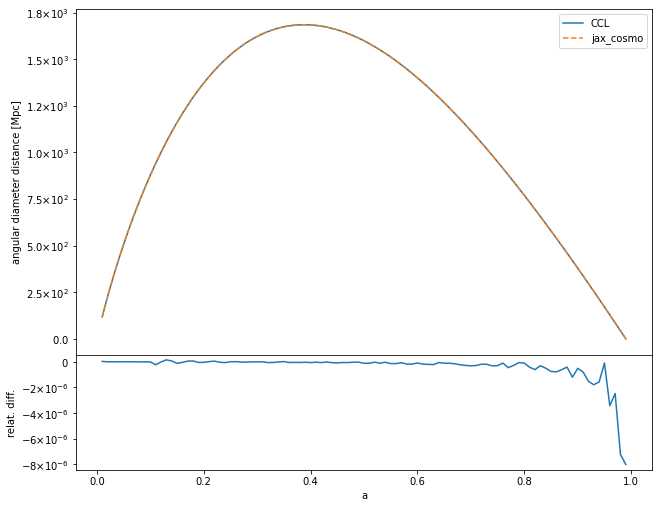

In [12]:
# Testing the angular diameter distance
fig1 = plt.figure(1, figsize=(10,8))
frame1=fig1.add_axes((.1,.3,.8,.6))
chi_ccl = ccl.angular_diameter_distance(cosmo_ccl, a)
chi_jax = background.angular_diameter_distance(cosmo_jax, a)/cosmo_jax.h

plt.plot(a, chi_ccl, label='CCL')
plt.plot(a, chi_jax, '--', label='jax_cosmo')
plt.legend()
plt.xlabel('a')
plt.ylabel('angular diameter distance [Mpc]')
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.1e"))


#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))
difference=(chi_ccl-chi_jax)/chi_ccl
plt.plot(a,difference)
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

plt.ylabel(r"relat. diff.");
plt.xlabel('a')

Text(0.5, 0, 'a')

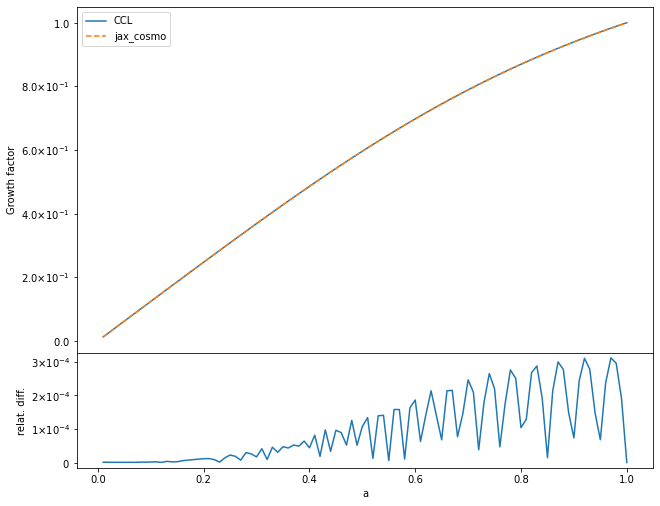

In [13]:
# Comparing the growth factor
fig1 = plt.figure(1, figsize=(10,8))
frame1=fig1.add_axes((.1,.3,.8,.6))
ccl_growth = ccl.growth_factor(cosmo_ccl,a)
jax_growth = background.growth_factor(cosmo_jax, a)

plt.plot(a, ccl_growth, label='CCL')
plt.plot(a, jax_growth, '--', label='jax_cosmo')
plt.legend()
plt.xlabel('a')
plt.ylabel('Growth factor')
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.1e"))


#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))
difference=(ccl_growth-jax_growth)/ccl_growth
plt.plot(a,difference)
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

plt.ylabel(r"relat. diff.");
plt.xlabel('a')

Text(0.5, 0, 'a')

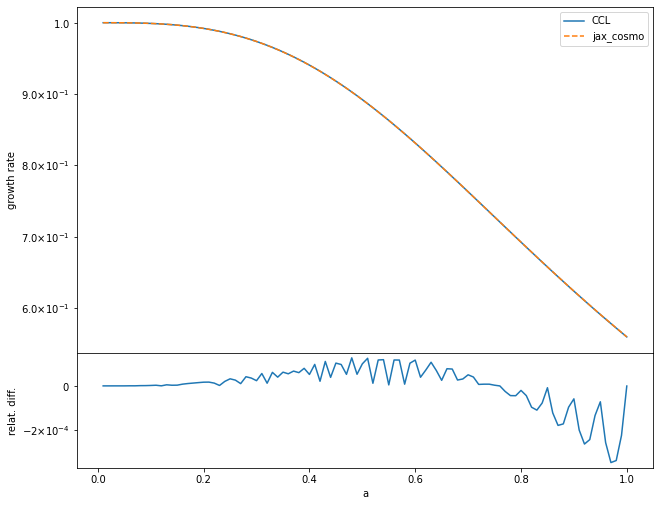

In [14]:
# Comparing linear growth rate
fig1 = plt.figure(1, figsize=(10,8))
frame1=fig1.add_axes((.1,.3,.8,.6))

ccl_growth_rate = ccl.growth_rate(cosmo_ccl,a)
jax_growth_rate = background.growth_rate(cosmo_jax, a)

plt.plot(a, ccl_growth_rate, label='CCL')
plt.plot(a, jax_growth_rate, '--', label='jax_cosmo')
plt.legend()
plt.xlabel('a')
plt.ylabel('growth rate')
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.1e"))

#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))
difference=(ccl_growth_rate-jax_growth_rate)/ccl_growth_rate
plt.plot(a,difference)
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

plt.ylabel(r"relat. diff.");
plt.xlabel('a')


## Comparing matter power spectrum

In [15]:
from jax_cosmo.power import linear_matter_power, nonlinear_matter_power

In [16]:
k = np.logspace(-3,1,300)
pklin_ccl = ccl.linear_matter_power(cosmo_ccl, k, 1.0)
pklin_jax = linear_matter_power(cosmo_jax, k/cosmo_jax.h, a=1.0)/cosmo_jax.h**3

Text(0.5, 0, 'k [Mpc]')

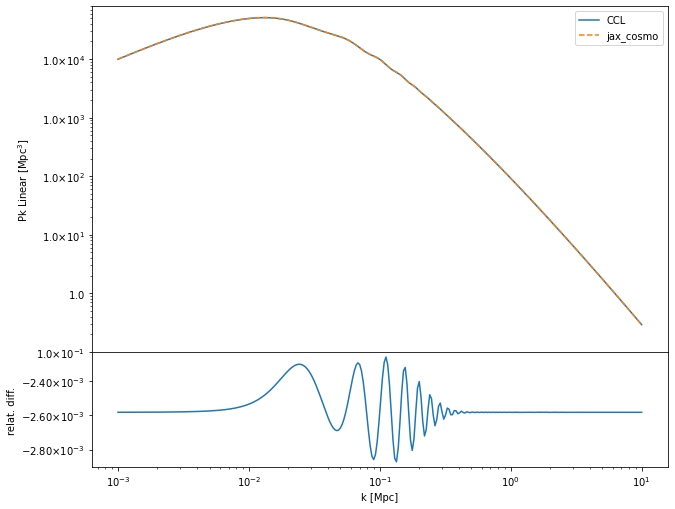

In [17]:
#Let's have a look at the linear power
fig1 = plt.figure(1, figsize=(10,8))
frame1=fig1.add_axes((.1,.3,.8,.6))



plt.loglog(k,pklin_ccl,label='CCL')
plt.loglog(k,pklin_jax, '--', label='jax_cosmo')
plt.legend()
plt.xlabel('k [Mpc]')
plt.ylabel(r'Pk Linear [Mpc$^{3}$]');
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.1e"))
plt.ylim([0.1,8e4])

#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))
difference=(pklin_ccl-pklin_jax)/pklin_ccl
plt.plot(k,difference)
plt.xscale("log")
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.2e"))
plt.ylabel(r"relat. diff.");
plt.xlabel('k [Mpc]')

In [18]:
pknl_ccl = ccl.nonlin_matter_power(cosmo_ccl, k, 1.0)
pknl_jax = nonlinear_matter_power(cosmo_jax, k/cosmo_jax.h, a=1.0)/cosmo_jax.h**3

Text(0.5, 0, 'k [Mpc]')

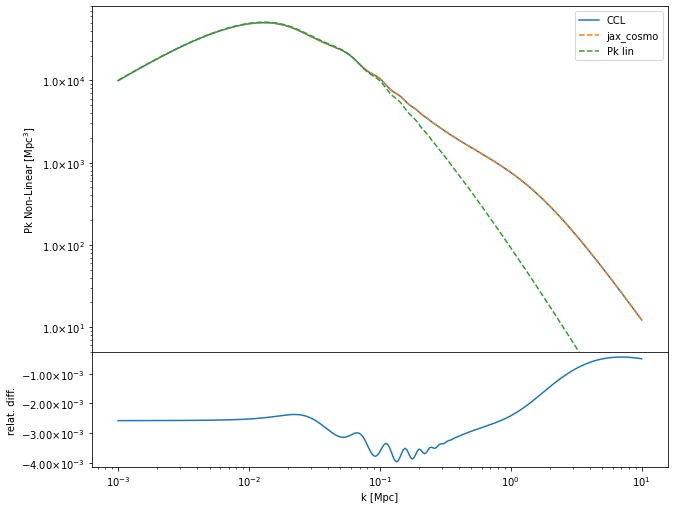

In [19]:
#Let's have a look at the non linear power
fig1 = plt.figure(1, figsize=(10,8))
frame1=fig1.add_axes((.1,.3,.8,.6))


plt.loglog(k,pknl_ccl,label='CCL')
plt.loglog(k,pknl_jax, '--', label='jax_cosmo')
plt.loglog(k,pklin_jax, '--', label='Pk lin')

plt.legend()
plt.xlabel('k [Mpc]')
plt.ylabel(r'Pk Non-Linear [Mpc$^{3}$]');
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.1e"))
plt.ylim([5,8e4])

#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))
difference=(pknl_ccl-pknl_jax)/pknl_ccl
plt.plot(k,difference)
plt.xscale("log")
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.2e"))

plt.xscale("log")
plt.ylabel(r"relat. diff.");
plt.xlabel('k [Mpc]')

In [20]:
#pklin_ccl=0
#pknl_ccl=0

## Comparing angular cl

In [21]:
from jax_cosmo.redshift import smail_nz

# Let's define a redshift distribution
# with a Smail distribution with a=1, b=2, z0=1
nz = smail_nz(1.,2., 1.)

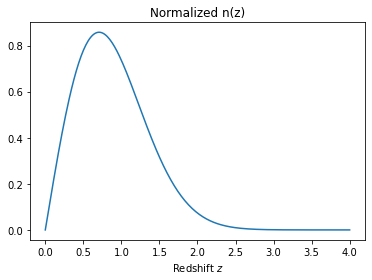

In [22]:
z = np.linspace(0,4,256)
plt.plot(z, nz(z))
plt.xlabel(r'Redshift $z$');
plt.title('Normalized n(z)');

In [34]:
from jax_cosmo.angular_cl import angular_cl
from jax_cosmo import probes

# Let's first compute some Weak Lensing cls
tracer_ccl = ccl.WeakLensingTracer(cosmo_ccl, (z, nz(z)), use_A_ia=False)
tracer_jax = probes.WeakLensing([nz])

ell = np.logspace(0.1,3)

cl_ccl = ccl.angular_cl(cosmo_ccl, tracer_ccl, tracer_ccl, ell)
cl_jax = angular_cl(cosmo_jax, ell, [tracer_jax])

Text(0.5, 0, '$\\ell$')

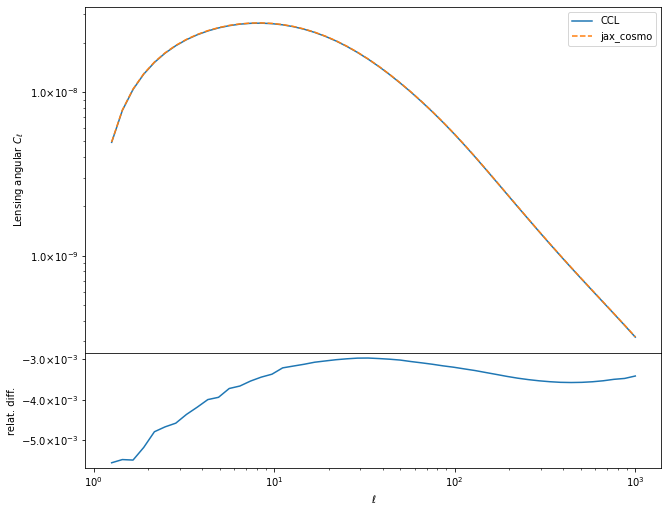

In [35]:
fig1 = plt.figure(1, figsize=(10,8))
frame1=fig1.add_axes((.1,.3,.8,.6))
plt.loglog(ell, cl_ccl,label='CCL')
plt.loglog(ell, cl_jax[0], '--', label='jax_cosmo')
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'Lensing angular $C_\ell$')
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.1e"))


#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))
difference=(cl_ccl-cl_jax[0])/cl_ccl
plt.plot(ell,difference)
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.1e"))

plt.xscale("log")
plt.ylabel(r"relat. diff.");
plt.xlabel(r'$\ell$')

In [30]:
# Let's try galaxy clustering now
from jax_cosmo.bias import constant_linear_bias

# We define a trivial bias model
bias = constant_linear_bias(1.)

tracer_ccl_n = ccl.NumberCountsTracer(cosmo_ccl,
                                      has_rsd=False,
                                      dndz=(z, nz(z)),
                                      bias=(z, bias(cosmo_jax, z)))
tracer_jax_n = probes.NumberCounts([nz], bias)

cl_ccl = ccl.angular_cl(cosmo_ccl, tracer_ccl_n, tracer_ccl_n, ell)
cl_jax = angular_cl(cosmo_jax, ell, [tracer_jax_n])

Text(0.5, 0, '$\\ell$')

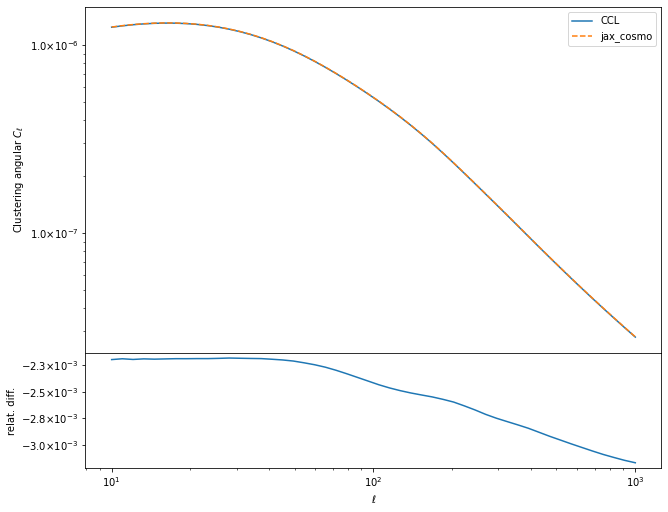

In [31]:
import jax_cosmo.constants as cst

fig1 = plt.figure(1, figsize=(10,8))
frame1=fig1.add_axes((.1,.3,.8,.6))

plt.loglog(ell, cl_ccl,label='CCL')
plt.loglog(ell, cl_jax[0], '--', label='jax_cosmo')
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'Clustering angular $C_\ell$')
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.1e"))


#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))
difference=(cl_ccl-cl_jax[0])/cl_ccl
plt.plot(ell,difference)
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.1e"))
plt.xscale("log")
plt.ylabel(r"relat. diff.");
plt.xlabel(r'$\ell$')

In [32]:
# And  finally.... a cross-spectrum

cl_ccl = ccl.angular_cl(cosmo_ccl, tracer_ccl, tracer_ccl_n, ell)
cl_jax = angular_cl(cosmo_jax, ell, [tracer_jax, tracer_jax_n])

Text(0.5, 0, '$\\ell$')

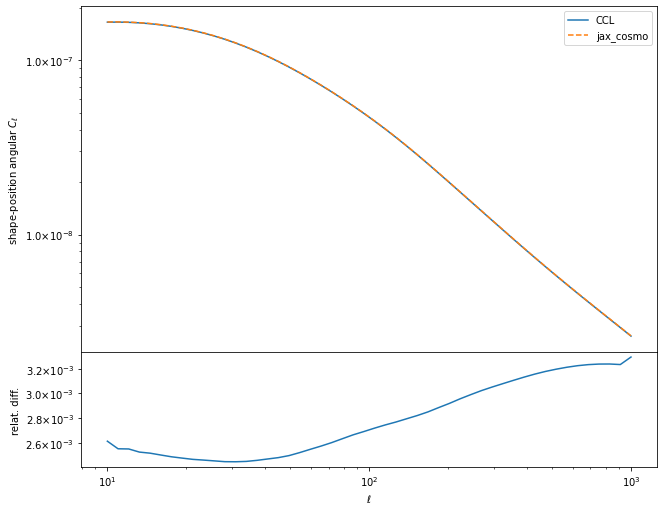

In [33]:
ell = np.logspace(1,3)

fig1 = plt.figure(1, figsize=(10,8))
frame1=fig1.add_axes((.1,.3,.8,.6))

plt.loglog(ell, cl_ccl,label='CCL')
plt.loglog(ell, cl_jax[1], '--', label='jax_cosmo')

plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'shape-position angular $C_\ell$')
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.1e"))

#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))
difference=np.abs(cl_ccl-cl_jax[1])/cl_ccl
plt.plot(ell,difference)
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.1e"))

plt.xscale("log")
plt.ylabel(r"relat. diff.");
plt.xlabel(r'$\ell$')